# Machine Learning Algorithms as Emulation Models

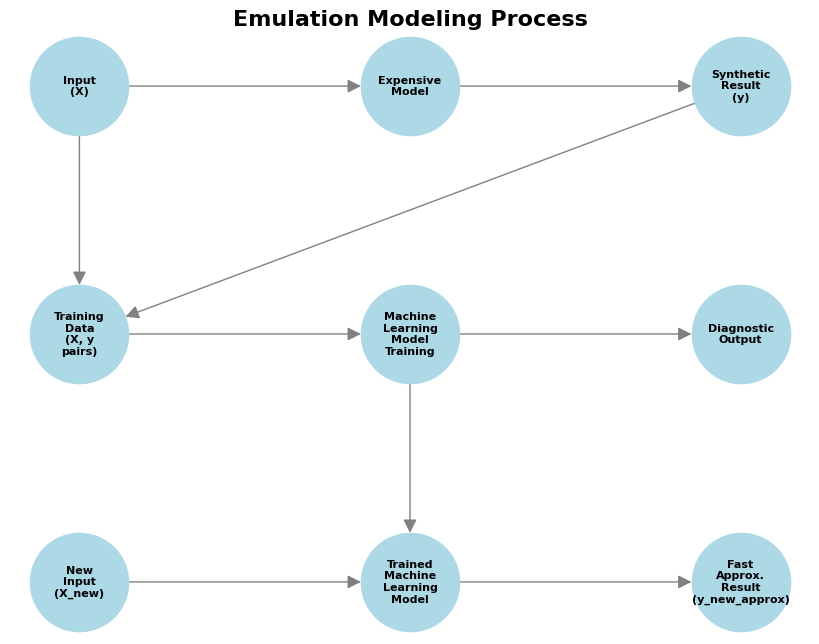

In [2]:
import helper_functions as hf
hf.plot_emulation_process_diagram()

**Emulation modeling** refers to the process of creating a simplified, fast approximation (or emulator) of a more complex, computationally expensive model. Instead of repeatedly running a time-consuming simulation, we train a machine learning model to predict the output of the expensive model based on input features.

**Machine learning** boils down to learning a mapping from input variables (X) to output variables (y). Given a set of inputs \( X \), which could be time-series features, temperature, etc., the goal is to predict the corresponding target values \( y \), such as power output or system performance. Machine learning algorithms learn this relationship by finding patterns in the data and generalizing them to make accurate predictions on unseen data.

**Overfitting** is a common issue in machine learning, because ML models can essentially memorize the dataset used to train them, rather than learning the underlying pattern. However, in emulation modeling, overfitting may not be a problem, as we are trying to recreate synthetic output rather than fit noisy real world data.  During diagnostic testing, the modeler needs to be aware of the amount of allowable overfitting for the problem at hand and the methods for avoiding or exploiting overfitting. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
import joblib
import os

import helper_functions as hf

# Generate Dummy Data

In [4]:
# Generate the dummy data
df = hf.generate_dummy_data()

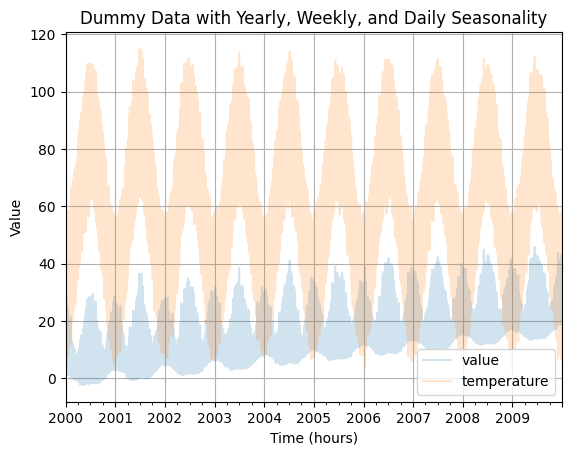

In [5]:
df.plot(alpha=.2)
plt.title('Dummy Data with Yearly, Weekly, and Daily Seasonality')
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.grid()

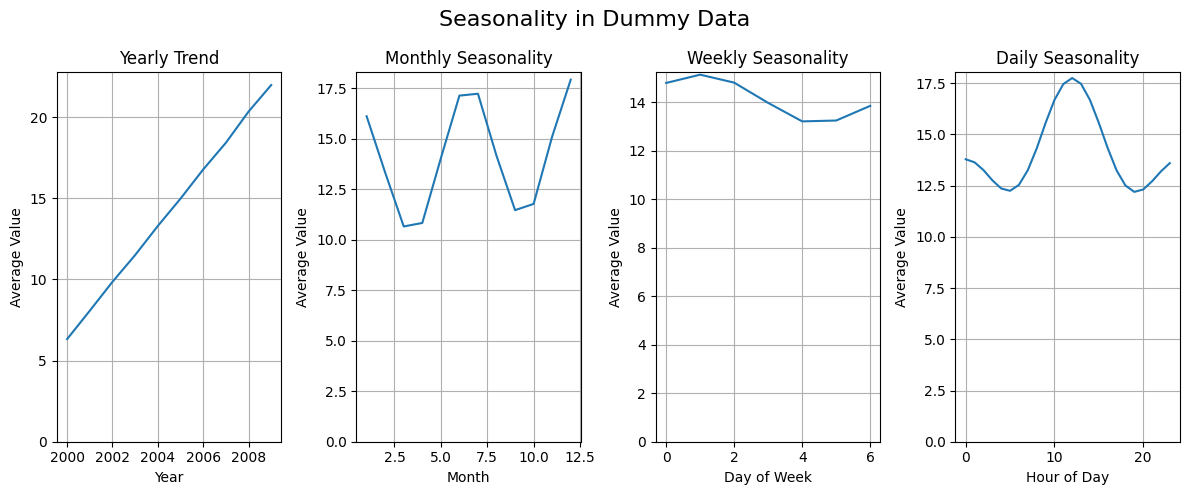

In [6]:
# Add year, month, day of week, and hour columns
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['hour_of_day'] = df.index.hour
hf.plot_dummy_data(df)

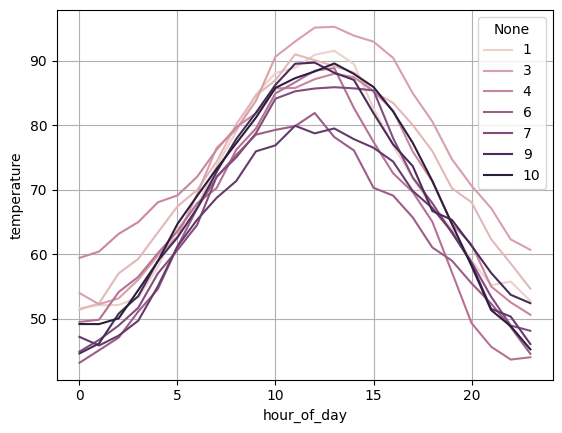

In [7]:
mask1 = df.year == 2005
mask2 = df.month == 9
plot_df = df.loc[mask1 & mask2].iloc[:240]
sns.lineplot(plot_df, x='hour_of_day', y='temperature', hue=plot_df.index.day)
plt.grid()

# Using K-Nearest Neighbors (KNN = 1) as a Lookup

K-Nearest Neighbors (KNN) can be effectively used as a lookup method by setting the number of neighbors (k) to 1, which causes it to return the value of the nearest data point.  If there is a feature that can identify the exact value to be returned, then this will work as a lookup.  

Define X and y.  

In [8]:
predictor_cols = ['temperature', 'year', 'month', 'day_of_week', 'hour_of_day']
X = df[predictor_cols]
y = df['value']

Create and fit the KNN model.  n_neighbors=1 means the model will use the nearest neighbor to make a prediction.

In [9]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X, y)

KNeighborsRegressor(n_neighbors=1)

Perform the lookup for 9/13/2005 for all hours.  

In [10]:
date = pd.to_datetime('2005-09-13')
mask = df.index.date == date.date()
X_new = df[mask][predictor_cols]
df_results = pd.DataFrame(index=X_new.index)

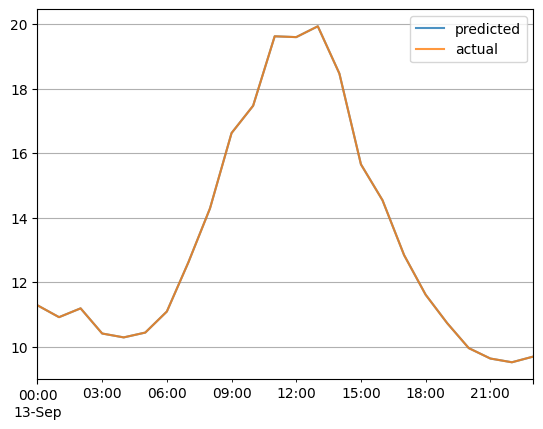

In [11]:
df_results['predicted'] = knn.predict(X_new)
df_results['actual'] = df[mask]['value'].values
df_results.plot(alpha=.8)
plt.grid()


# Decision Tree Algorithm
A decision tree essentially partitions data into groups in a principled way.  The mean of the data in each partition is used to make a prediction.


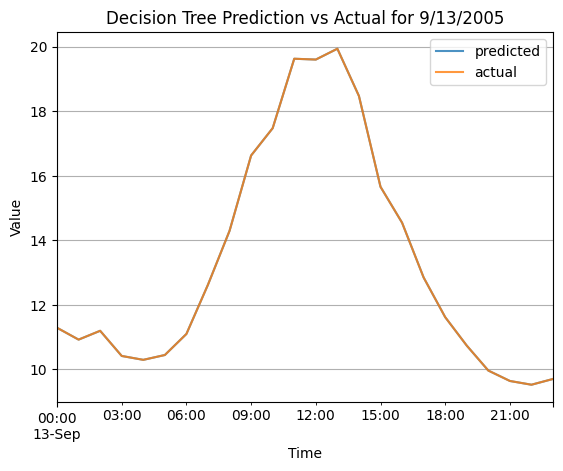

In [12]:
# Create and fit the Decision Tree model
dt = DecisionTreeRegressor()
dt.fit(X, y)

# Perform the predicton for 9/13/2005 for all hours as before
df_results['predicted'] = dt.predict(X_new)

# Plot the results
df_results.plot(alpha=0.8)
plt.title('Decision Tree Prediction vs Actual for 9/13/2005')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()

We can see that the decision tree is acting as a lookup and providing an exact replication of the data.  This is because the tree went very deep by default:  

In [13]:
# Print some information about the original tree
print(f"Number of nodes: {dt.tree_.node_count}")
print(f"Maximum depth: {dt.tree_.max_depth}")

Number of nodes: 175199
Maximum depth: 37


To understand how a decision tree works, we can make a shallower tree and visualize how it works.  

Text(0.5, 1.0, 'Decision Tree Visualization (max_depth=3)')

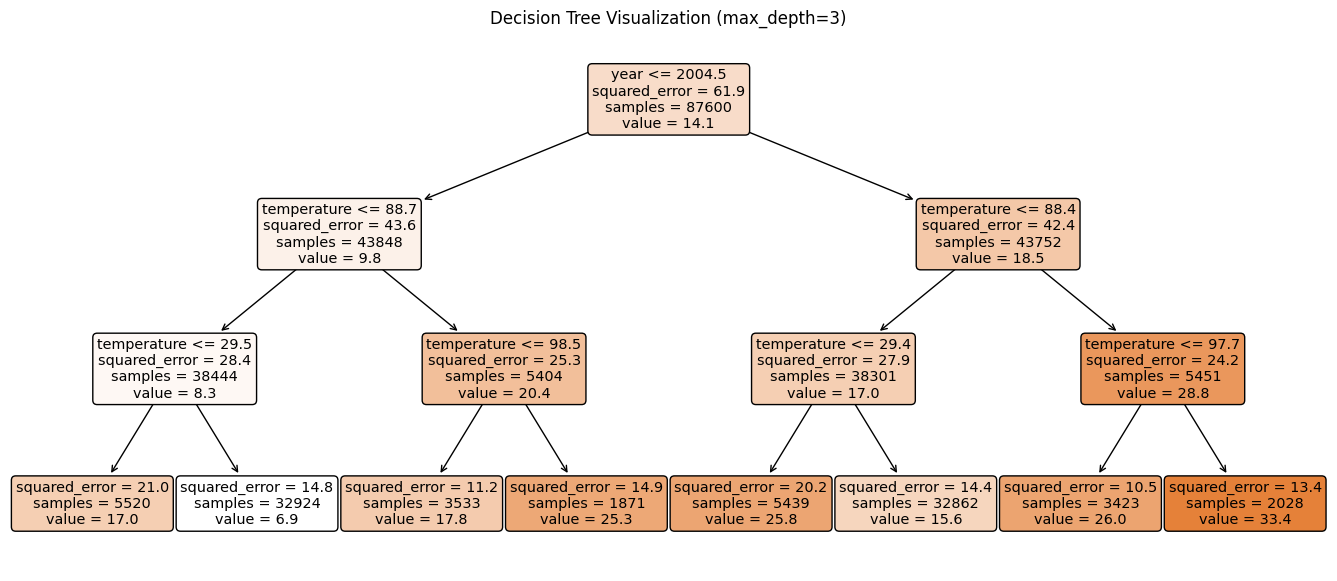

In [14]:
dt_shallow = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_shallow.fit(X, y)
plt.figure(figsize=(17,7))
plot_tree(dt_shallow, feature_names=predictor_cols, filled=True, rounded=True,  precision=1)
plt.title("Decision Tree Visualization (max_depth=3)")

The decision tree has binned the data into 8 total bins.  When making a prediction, each data point is assigned to one bin based on the decision framework.  The result is shown below.  

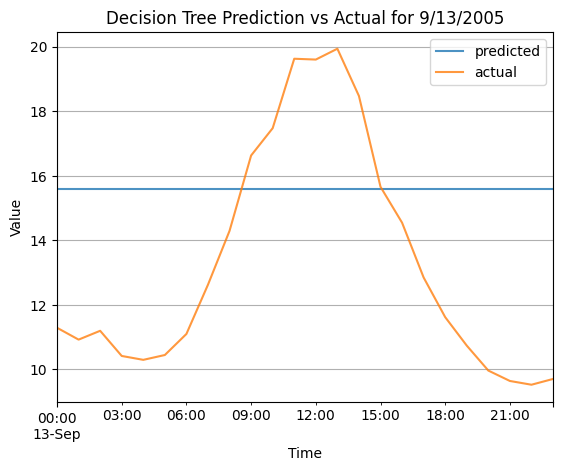

In [15]:
# Perform the predicton for 9/13/2005 for all hours as before
df_results['predicted'] = dt_shallow.predict(X_new)

# Plot the results
df_results.plot(alpha=0.8)
plt.title('Decision Tree Prediction vs Actual for 9/13/2005')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()

A deeper tree will overfit the data and a shallower tree with underfit the data.  The modeler needs to choose the correct depth for the purpose at hand.  

# Tree Ensembles 
When overfitting is an issue, then ensembles of trees are used.  These can be random forests or boosted trees such as `lgbm` or `xgb`. **Boosted trees are a common go-to for these sorts of problems.**

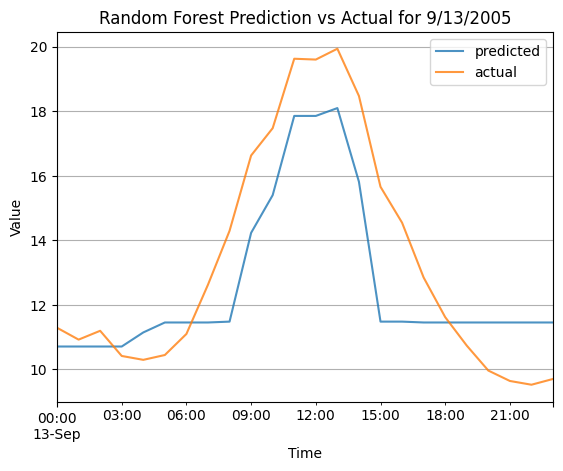

In [16]:
# Create and fit the Decision Tree model
rf = RandomForestRegressor(max_depth=7)
rf.fit(X, y)

# Perform the predicton for 9/13/2005 for all hours as before
df_results['predicted'] = rf.predict(X_new)

# Plot the results
df_results.plot(alpha=0.8)
plt.title('Random Forest Prediction vs Actual for 9/13/2005')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()

# Neural Network

Note that neural networks need to have data scaled to work well.  

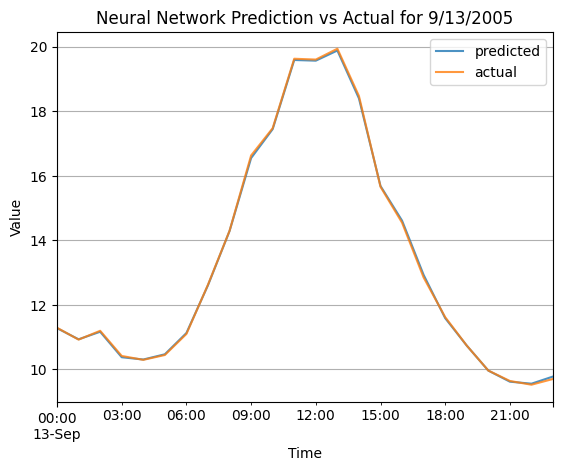

In [17]:
# Make a neural network with some pretty big hidden layers
nn = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit model
nn.fit(X_scaled, y)

# Perform the estimate for 9/13/2005 for all hours as before
X_new_scaled = scaler.transform(X_new)
df_results['predicted'] = nn.predict(X_new_scaled)

# Plot the results
df_results.plot(alpha=0.8)
plt.title('Neural Network Prediction vs Actual for 9/13/2005')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()

# Fit, export, reload, use the ML model

In [18]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=500))
])

# Fit the pipeline
pipeline.fit(X, y)

# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Export the pipeline
pipeline_filename = 'nn_pipeline.joblib'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved as: {os.path.join(current_dir, pipeline_filename)}")

Current working directory: c:\Users\Gbrunkhorst\OneDrive - City of Tacoma\Documents\Code\TP_datascience_public\TP_datascience_public\emulation
Pipeline saved as: c:\Users\Gbrunkhorst\OneDrive - City of Tacoma\Documents\Code\TP_datascience_public\TP_datascience_public\emulation\nn_pipeline.joblib


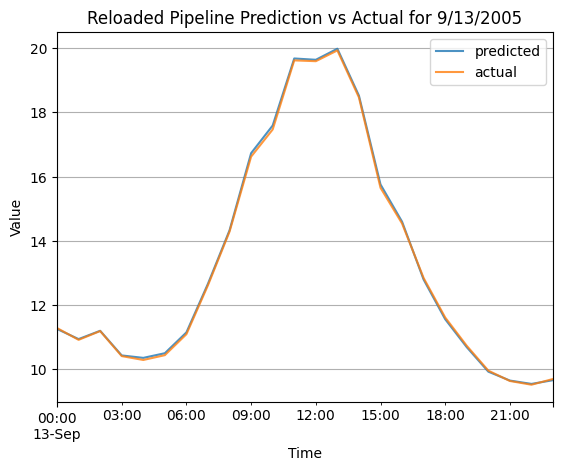

In [19]:
# Reload the pipeline
loaded_pipeline = joblib.load(pipeline_filename)

# Use the loaded pipeline to make predictions on new data
predictions = loaded_pipeline.predict(X_new)

df_results['predicted'] = predictions
df_results.plot(alpha=0.8)
plt.title('Reloaded Pipeline Prediction vs Actual for 9/13/2005')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()
plt.show()

# Things this Notebook Didn't Address

This notebook provided an introduction to various machine learning algorithms for emulation modeling. However, there are several important aspects of model development, evaluation, and validation that weren't covered:

1. Train-Test Split: We didn't separate our data into training and testing sets, which is crucial for assessing model performance on unseen data.

2. Cross-Validation: K-fold cross-validation wasn't implemented, which helps in estimating how well our model generalizes to unseen data.

3. Quantitative Model Checking: We didn't use metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or R-squared to quantitatively assess model performance.

4. Hyperparameter Tuning: We didn't explore techniques like Grid Search or Random Search to optimize model hyperparameters.

5. Feature Importance: For tree-based models, we didn't analyze feature importance to understand which inputs have the most impact on predictions.

6. Model Comparison: While we implemented several algorithms, we didn't systematically compare their performance.

7. Residual Analysis: We didn't examine the residuals to check for patterns or heteroscedasticity.

8. Uncertainty Quantification: We didn't discuss methods for quantifying uncertainty in our predictions, which is often crucial in emulation modeling.

9. Time Series Specific Techniques: Although our data has a time component, we didn't explore time series specific models with lags.

10. Model Interpretability: We didn't delve into techniques for interpreting complex models, such as SHAP values for tree ensembles or neural networks.

11. Data Preprocessing: While we did some basic feature engineering, we didn't explore more advanced techniques like polynomial features or interaction terms.

12. Handling Non-Linear Relationships: We didn't explicitly address how to handle non-linear relationships between features and target variables.

These aspects are crucial for developing robust and reliable emulation models. In a real-world scenario, addressing these points would be necessary to ensure the model's accuracy, reliability, and generalizability.